In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap as sp

from sklearn.model_selection import train_test_split, StratifiedKFold

from scipy import stats

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer

from catboost import CatBoostRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_percentage_error

In [2]:
pd.options.display.max_columns = None
# pd.options.display.max_rows = None

# I/ Exploration

In [3]:
df = pd.read_csv('media prediction and its cost.csv')
df.head(5)

,food_category,food_department,food_family,store_sales(in millions),store_cost(in millions),unit_sales(in millions),promotion_name,sales_country,marital_status,gender,total_children,education,member_card,occupation,houseowner,avg_cars_at home(approx),avg. yearly_income,num_children_at_home,avg_cars_at home(approx).1,brand_name,SRP,gross_weight,net_weight,recyclable_package,low_fat,units_per_case,store_type,store_city,store_state,store_sqft,grocery_sqft,frozen_sqft,meat_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,media_type,cost
0,Breakfast Foods,Frozen Foods,Food,7.36,2.7232,4.0,Bag Stuffers,USA,M,F,1.0,Partial High School,Normal,Skilled Manual,Y,1.0,$10K - $30K,1.0,1.0,Carrington,1.84,19.70,17.70,1.0,0.0,17.0,Deluxe Supermarket,Salem,OR,27694.0,18670.0,5415.0,3610.0,1.0,1.0,1.0,1.0,1.0,"Daily Paper, Radio",126.62
1,Breakfast Foods,Frozen Foods,Food,5.52,2.5944,3.0,Cash Register Lottery,USA,M,M,0.0,Bachelors Degree,Silver,Professional,Y,4.0,$50K - $70K,0.0,4.0,Carrington,1.84,19.70,17.70,1.0,0.0,17.0,Deluxe Supermarket,Salem,OR,27694.0,18670.0,5415.0,3610.0,1.0,1.0,1.0,1.0,1.0,"Daily Paper, Radio",59.86
2,Breakfast Foods,Frozen Foods,Food,3.68,1.3616,2.0,High Roller Savings,USA,S,F,4.0,Partial High School,Normal,Manual,N,1.0,$10K - $30K,0.0,1.0,Carrington,1.84,19.70,17.70,1.0,0.0,17.0,Deluxe Supermarket,Salem,OR,27694.0,18670.0,5415.0,3610.0,1.0,1.0,1.0,1.0,1.0,"Daily Paper, Radio",84.16
3,Breakfast Foods,Frozen Foods,Food,3.68,1.1776,2.0,Cash Register Lottery,USA,M,F,2.0,High School Degree,Bronze,Manual,Y,2.0,$30K - $50K,2.0,2.0,Carrington,1.84,19.70,17.70,1.0,0.0,17.0,Deluxe Supermarket,Salem,OR,27694.0,18670.0,5415.0,3610.0,1.0,1.0,1.0,1.0,1.0,In-Store Coupon,95.78
4,Breakfast Foods,Frozen Foods,Food,4.08,1.4280,3.0,Double Down Sale,USA,M,M,0.0,Partial High School,Bronze,Skilled Manual,N,2.0,$30K - $50K,0.0,2.0,Golden,1.36,7.12,5.11,0.0,1.0,29.0,Deluxe Supermarket,Salem,OR,27694.0,18670.0,5415.0,3610.0,1.0,1.0,1.0,1.0,1.0,Radio,50.79


In [4]:
#Check du type, de la proportion de N/A et du nombre de valeurs uniques pour chaque colonne

print(f"Dataset Shape: {df.shape}") 
summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
summary = summary.reset_index()
summary['Missing'] = df.isnull().sum().values
summary['PercMissing'] = df.isnull().sum().values / df.isnull().count().values
summary['Uniques'] = df.nunique().values
 
print('**Variable Description of  data:**')
summary

Dataset Shape: (60428, 40)
**Variable Description of  data:**


,index,dtypes,Missing,PercMissing,Uniques
0,food_category,object,0,0.0,45
1,food_department,object,0,0.0,22
2,food_family,object,0,0.0,3
3,store_sales(in millions),float64,0,0.0,1033
4,store_cost(in millions),float64,0,0.0,9919
5,unit_sales(in millions),float64,0,0.0,6
6,promotion_name,object,0,0.0,49
7,sales_country,object,0,0.0,3
8,marital_status,object,0,0.0,2
9,gender,object,0,0.0,2


In [5]:
#Pretraitement Colonne Date

date_columns = []

for col in date_columns:
    df[col] = df[col].astype(str).str[:10]
    df[col+'_year'] = df[col].str[:4].astype(float)
    df[col+'_month'] = df[col].str[5:7].astype(str)
    df[col+'_day'] = df[col].str[8:].astype(str)

In [6]:
#Colonne Target
target_column = "cost"

#Colonnes Numériques
numerical_columns = [
    'store_sales(in millions)','store_cost(in millions)','unit_sales(in millions)','total_children',
    'avg_cars_at home(approx)','num_children_at_home','SRP','gross_weight',
    'recyclable_package','low_fat','units_per_case','store_sqft','grocery_sqft','frozen_sqft',
]

#Colonnes Catégorielles
categorical_columns = [
    'food_category','food_family','promotion_name','marital_status',
    'gender', 'education','member_card','occupation','houseowner','avg. yearly_income',
    'brand_name','store_type','store_city','store_state',
    'coffee_bar','video_store','prepared_food','florist', 'media_type'
]


#On force le type pour chaque type de colonnes
for l in numerical_columns: df[l] = df[l].astype('float')
for l in categorical_columns: df[l] = df[l].astype('string').fillna("None").astype('category')
df[target_column] = df[target_column].astype('float')

#On ordonne notre df
df = df[ [target_column] + numerical_columns + categorical_columns ]

#On supprime les lignes ou la target est n/a
df = df.dropna(subset=target_column)

In [7]:
df.describe()

,cost,store_sales(in millions),store_cost(in millions),unit_sales(in millions),total_children,avg_cars_at home(approx),num_children_at_home,SRP,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,grocery_sqft,frozen_sqft
count,60428.000000,60428.000000,60428.000000,60428.000000,60428.000000,60428.000000,60428.000000,60428.000000,60428.000000,60428.000000,60428.000000,60428.000000,60428.000000,60428.000000,60428.000000
mean,99.262366,6.541031,2.619460,3.093169,2.533875,2.200271,0.829351,2.115258,13.806433,0.558665,0.350434,18.860694,27988.477494,19133.799696,5312.852552
std,30.011257,3.463047,1.453009,0.827677,1.490165,1.109644,1.303424,0.932829,4.622693,0.496551,0.477110,10.258555,5701.022090,3987.395735,1575.907263
min,50.790000,0.510000,0.163200,1.000000,0.000000,0.000000,0.000000,0.500000,6.000000,0.000000,0.000000,1.000000,20319.000000,13305.000000,2452.000000
25%,69.650000,3.810000,1.500000,3.000000,1.000000,1.000000,0.000000,1.410000,9.700000,0.000000,0.000000,10.000000,23593.000000,16232.000000,4746.000000
50%,98.520000,5.940000,2.385600,3.000000,3.000000,2.000000,0.000000,2.130000,13.600000,1.000000,0.000000,19.000000,27694.000000,18670.000000,5062.000000
75%,126.620000,8.670000,3.484025,4.000000,4.000000,3.000000,1.000000,2.790000,17.700000,1.000000,1.000000,28.000000,30797.000000,22123.000000,5751.000000
max,149.750000,22.920000,9.726500,6.000000,5.000000,4.000000,5.000000,3.980000,21.900000,1.000000,1.000000,36.000000,39696.000000,30351.000000,9184.000000


# II/ Check Variables
## a) Colinearity

In [8]:
corr=df[numerical_columns].corr()
corr.style.background_gradient(cmap='coolwarm')

,store_sales(in millions),store_cost(in millions),unit_sales(in millions),total_children,avg_cars_at home(approx),num_children_at_home,SRP,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,grocery_sqft,frozen_sqft
store_sales(in millions),1.000000,0.954685,0.503482,0.083313,0.004498,0.032437,0.833478,0.036179,0.034293,-0.006134,-0.010630,0.015543,0.010442,0.017886
store_cost(in millions),0.954685,1.000000,0.480087,0.079058,0.002865,0.027576,0.795880,0.034237,0.030213,-0.005976,-0.009792,0.017877,0.012884,0.019245
unit_sales(in millions),0.503482,0.480087,1.000000,0.163188,0.023667,0.066725,-0.002358,0.001255,0.001599,-0.001129,0.000084,0.031464,0.024857,0.030563
total_children,0.083313,0.079058,0.163188,1.000000,0.098110,0.394709,0.000545,-0.000186,0.002794,-0.002824,0.002307,0.000555,0.018526,-0.026926
avg_cars_at home(approx),0.004498,0.002865,0.023667,0.098110,1.000000,0.130841,-0.007921,0.004588,0.003725,-0.004312,-0.007265,-0.015815,-0.017694,-0.007470
num_children_at_home,0.032437,0.027576,0.066725,0.394709,0.130841,1.000000,-0.000477,-0.002480,0.001380,-0.001818,0.000118,0.006150,0.025008,-0.024624
SRP,0.833478,0.795880,-0.002358,0.000545,-0.007921,-0.000477,1.000000,0.043332,0.042013,-0.005527,-0.011951,0.001663,-0.000505,0.004375
gross_weight,0.036179,0.034237,0.001255,-0.000186,0.004588,-0.002480,0.043332,1.000000,0.052340,-0.033883,-0.011754,-0.005254,-0.004749,-0.004195
recyclable_package,0.034293,0.030213,0.001599,0.002794,0.003725,0.001380,0.042013,0.052340,1.000000,-0.026494,-0.002496,0.001358,0.001562,0.000575
low_fat,-0.006134,-0.005976,-0.001129,-0.002824,-0.004312,-0.001818,-0.005527,-0.033883,-0.026494,1.000000,0.030133,0.001675,-0.002664,0.007682


In [9]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    r, k = confusion_matrix.shape
    return np.sqrt(chi2 / (n * (min(r, k) - 1)))

cramers_v_matrix = pd.DataFrame(index=categorical_columns, columns=categorical_columns)
for col1 in categorical_columns:
    for col2 in categorical_columns:
        cramers_v_matrix.loc[col1, col2] = cramers_v(df[col1], df[col2])
        
cramers_v_matrix.astype(float).style.background_gradient(cmap='coolwarm')

,food_category,food_family,promotion_name,marital_status,gender,education,member_card,occupation,houseowner,avg. yearly_income,brand_name,store_type,store_city,store_state,coffee_bar,video_store,prepared_food,florist,media_type
food_category,1.000000,0.957488,0.027656,0.024136,0.026304,0.026781,0.025768,0.025693,0.024182,0.026064,0.610251,0.026165,0.026763,0.026740,0.026587,0.028374,0.024793,0.025910,0.027697
food_family,0.957488,1.000000,0.027871,0.013723,0.006768,0.004784,0.005754,0.007334,0.006344,0.009664,0.922818,0.011291,0.015738,0.010959,0.010463,0.011108,0.006645,0.005843,0.009872
promotion_name,0.027656,0.027871,1.000000,0.077596,0.062140,0.065849,0.061938,0.073235,0.065386,0.071553,0.042150,0.373784,0.405359,0.425230,0.467479,0.487258,0.405597,0.449722,0.462400
marital_status,0.024136,0.013723,0.077596,0.999967,0.023883,0.026107,0.236498,0.035139,0.282006,0.052762,0.048859,0.035150,0.082397,0.050580,0.020968,0.008309,0.020919,0.007518,0.028671
gender,0.026304,0.006768,0.062140,0.023883,0.999967,0.018737,0.039491,0.031584,0.003700,0.056168,0.045219,0.029606,0.099052,0.096501,0.029902,0.011296,0.027306,0.009105,0.030100
education,0.026781,0.004784,0.065849,0.026107,0.018737,1.000000,0.357146,0.436070,0.066578,0.524558,0.042816,0.028289,0.067439,0.053314,0.026899,0.030380,0.015650,0.028821,0.034434
member_card,0.025768,0.005754,0.061938,0.236498,0.039491,0.357146,1.000000,0.247856,0.120572,0.524474,0.041638,0.028179,0.070542,0.057638,0.043360,0.020744,0.007734,0.038827,0.034772
occupation,0.025693,0.007334,0.073235,0.035139,0.031584,0.436070,0.247856,1.000000,0.104348,0.432999,0.041707,0.021718,0.082837,0.056062,0.030213,0.012405,0.025091,0.028729,0.037241
houseowner,0.024182,0.006344,0.065386,0.282006,0.003700,0.066578,0.120572,0.104348,0.999965,0.174826,0.043299,0.018599,0.075242,0.055102,0.003180,0.011337,0.011947,0.000808,0.032497
avg. yearly_income,0.026064,0.009664,0.071553,0.052762,0.056168,0.524558,0.524474,0.432999,0.174826,1.000000,0.042854,0.044909,0.078324,0.055428,0.044680,0.052607,0.030320,0.043639,0.037079


## b) Distribution

In [10]:
# nb_cols=3
# fig = plt.figure(figsize=(8,6))
# fig.suptitle('Distribution of continuous features', fontsize=11)
# gs = fig.add_gridspec(int(np.ceil(len(numerical_columns)/nb_cols)),nb_cols)
# gs.update(wspace=0.3, hspace=0.4)
# for i, col in enumerate(numerical_columns):
#     ax = fig.add_subplot(gs[int(np.floor(i/nb_cols)),i%nb_cols])
#     sns.histplot(df[col], ax=ax)

In [11]:
# fig = plt.figure(figsize=(8,6))
# fig.suptitle('Distribution of categorical features', fontsize=11)
# gs = fig.add_gridspec(int(np.ceil(len(categorical_columns)/nb_cols)),nb_cols)
# gs.update(wspace=0.3, hspace=0.4)
# for i, col in enumerate(categorical_columns):
#     ax = fig.add_subplot(gs[int(np.floor(i/nb_cols)),i%nb_cols])
#     plot = sns.countplot(df, x=col)
#     plt.ylabel('')

# III/ Preprocessing

In [12]:
#Train/test split
 
X = df.drop(target_column, axis=1)
y = df[target_column]
 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
 
n_train=y.size
n_test=y_test.size
 
n,p=X.shape
  
print("Kolmogorov p_value (train/test même distrib):", np.round(stats.ks_2samp(y_train, y_test)[1],3))
print("Shape of train X,y,Y: ",X_train.shape, y_train.shape)
print("Shape of test X,y,Y: ",X_test.shape, y_test.shape)

Kolmogorov p_value (train/test même distrib): 0.281
Shape of train X,y,Y:  (48342, 33) (48342,)
Shape of test X,y,Y:  (12086, 33) (12086,)


In [13]:
target_transformer = Pipeline(steps=[
    ('transform', FunctionTransformer(lambda x: np.log(x + 1))),  
    ('scaler', StandardScaler())
])


target_transformer.fit(y_train.values.reshape(-1, 1))

Pipeline(steps=[('transform',
                 FunctionTransformer(func=<function <lambda> at 0x00000279ED35D6C0>)),
                ('scaler', StandardScaler())])

In [14]:
def f(y):
    return target_transformer.transform(y.values.reshape(-1,1)).ravel()
    
def f_inv(y):
    return np.exp(target_transformer.named_steps['scaler'].inverse_transform(y.reshape(-1,1))).ravel() - 1

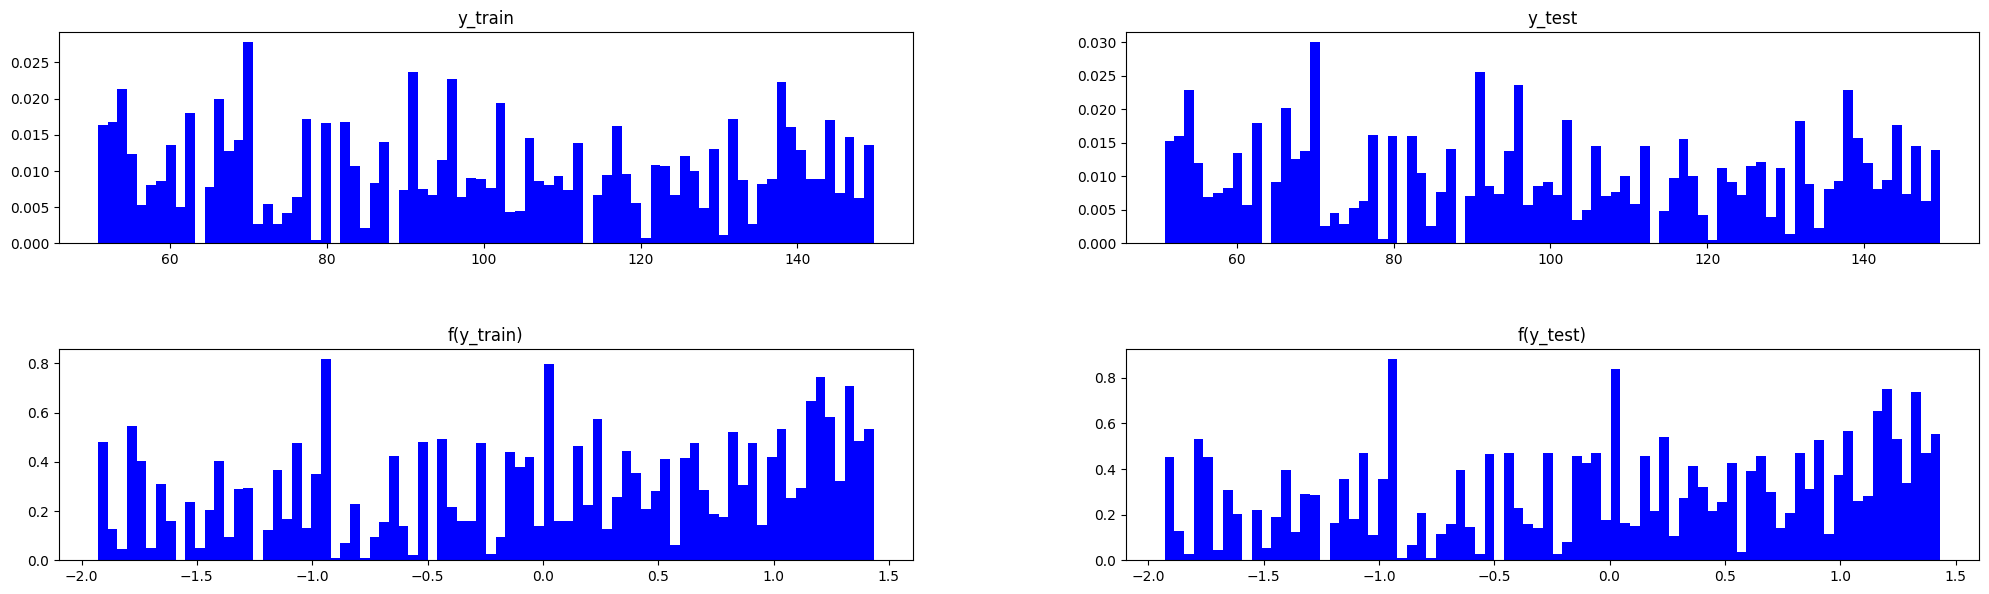

In [15]:
#Check distrib
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2,ncols=2)
 
ax0.hist(y_train, color = 'blue', bins = 80, density= True)
ax0.set_title("y_train")
 
ax1.hist(y_test, color = 'blue', bins = 80, density= True)
ax1.set_title("y_test")
 
ax2.hist(f(y_train), color = 'blue', bins = 80, density= True)
ax2.set_title("f(y_train)")
 
ax3.hist(f(y_test), color = 'blue', bins = 80, density= True)
ax3.set_title("f(y_test)")
 
plt.subplots_adjust(left=-1, bottom=-1, right=2, top=0.1, wspace=0.25, hspace=0.5)

# IV/ Modelisation

In [16]:
reg_catboost = CatBoostRegressor(cat_features = categorical_columns, verbose = False)
reg_catboost = reg_catboost.fit(X_train, f(y_train), verbose = False, plot=True, eval_set= (X_test, f(y_test)))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [17]:
#Predict:
y_hat_train = f_inv(reg_catboost.predict(X_train))
y_hat_test = f_inv(reg_catboost.predict(X_test))

# V/ Evaluation
## a) Loss

In [18]:
#Loss
print("Train loss (RMSE): ", np.sqrt(mean_squared_error(y_train, y_hat_train)))
print("Test loss: (RMSE)", np.sqrt(mean_squared_error(y_test, y_hat_test)))
print("Test loss: (RMSE - Random)", np.std(y_test))
print("-"*50)
print("Train loss: (MAE)", mean_absolute_error(y_train, y_hat_train))
print("Test loss: (MAE)", mean_absolute_error(y_test, y_hat_test))
print("Test loss: (MAE - Random))", np.linalg.norm(y_test-y_train.mean(),1)/n_test)
print("-"*50)
print("Train loss: (VAR)", explained_variance_score(y_train, y_hat_train))
print("Test loss: (VAR)", explained_variance_score(y_test, y_hat_test))

Train loss (RMSE):  1.591967042414013
Test loss: (RMSE) 1.5932657011237459
Test loss: (RMSE - Random) 30.058637059380278
--------------------------------------------------
Train loss: (MAE) 0.76200634944626
Test loss: (MAE) 0.7697631317592869
Test loss: (MAE - Random)) 26.06505440900143
--------------------------------------------------
Train loss: (VAR) 0.9971895807753026
Test loss: (VAR) 0.997198959682641


## b) Distribution

Text(0.5, 1.0, 'y_hat_test')

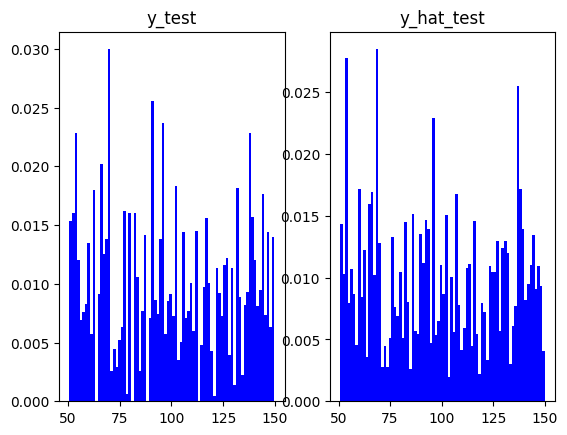

In [19]:
fig, (ax0, ax1) = plt.subplots(nrows=1,ncols=2)
 
ax0.hist(y_test, color = 'blue', bins = 80, density= True)
ax0.set_title("y_test")
 
ax1.hist(y_hat_test, color = 'blue', bins = 80, density= True)
ax1.set_title("y_hat_test")

# VI/ Interpretability 

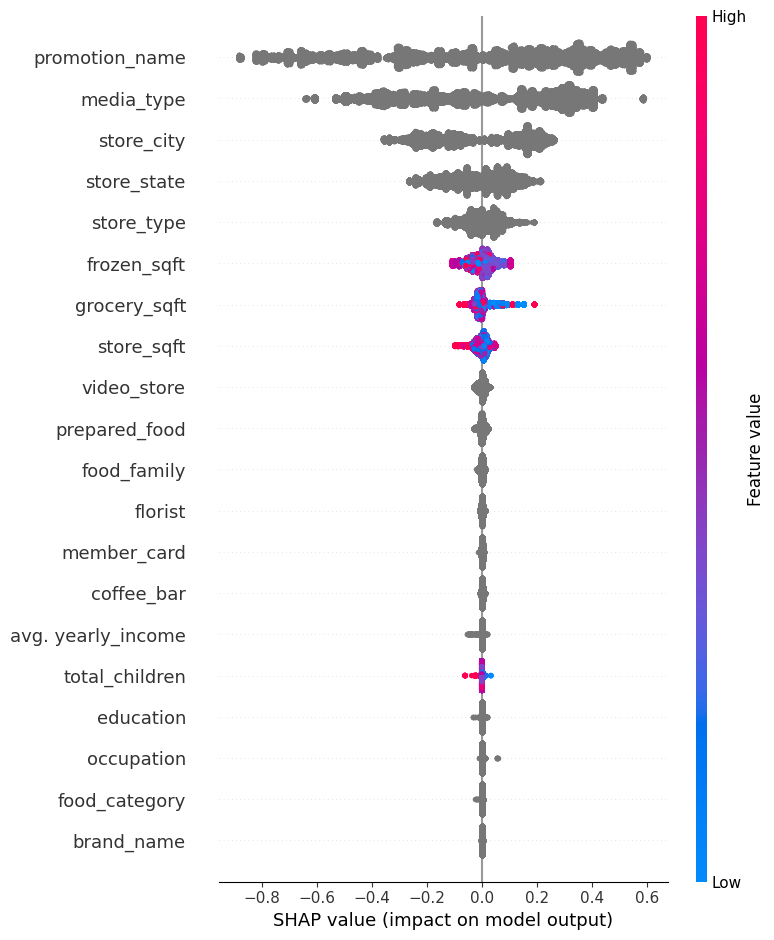

In [20]:
explainer = sp.TreeExplainer(reg_catboost)
shap_values = explainer.shap_values(X_train)
 
sp.summary_plot(shap_values, X_train)

# VII/ Final training

In [21]:
reg_catboost = CatBoostRegressor(cat_features = categorical_columns)
reg_catboost = reg_catboost.fit(X, f(y), verbose = False, plot=True, eval_set= (X_test, f(y_test)))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [22]:
#Result model:

#Probabilités
y_hat = f_inv(reg_catboost.predict(X))

#Loss
print("Train loss: ", np.sqrt(mean_squared_error(y, y_hat)))

Train loss:  1.4016904903329173
